In [188]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from collections import defaultdict
import os
from tqdm import tqdm, trange

from datetime import datetime

from prettytable import PrettyTable

import warnings
warnings.simplefilter("ignore")

In [551]:
def compute_orderflow_one_bar(bar, unit=1):
    high = bar['price'].max()
    low = bar['price'].min()
    
    vol = bar['主动买/卖']
    price_qty = np.zeros((int((high-low)/unit) + 1, 3))
    price_qty[:,0] = [low + i * unit for i in range(int((high-low)/unit) + 1)]
    price_qty[:,1] = [np.abs(np.sum(np.minimum(vol[bar['price'] == low + i * unit], 0))) \
                      for i in range(int((high-low)/unit) + 1)]
    price_qty[:,2] = [np.sum(np.maximum(vol[bar['price'] == low + i * unit], 0)) \
                      for i in range(int((high-low)/unit) + 1)]
    
    return price_qty

class FeatureeGenerator:
    def __init__(self, data, unit, freq):
        self.data = data
        price_diff = self.data['price'].diff(1).fillna(0.01)
        sign = 2 * (price_diff > 0) - 1
        zero_idx = np.where(price_diff == 0)[0]
        sign[zero_idx] = sign[zero_idx - 1]
        
        self.data['主动买/卖'] = self.data['volume'] * sign
        
        self.unit = unit
        self.freq = freq
        self.of = {}
        self._of_exist = False
        
    def compute_orderflow(self):

        df = self.data
        stime = df.index[0].replace(second=0,microsecond=0)
        etime = stime + pd.Timedelta(self.freq)
        
        while stime <= df.index[-1]:
            sub_df = df.loc[stime:etime]
            if len(sub_df) == 0:
                stime = etime
                etime = stime + pd.Timedelta(self.freq)
                continue
            open_ = sub_df['price'].iloc[0]
            close_ = sub_df['price'].iloc[-1]
            high_ = sub_df['price'].max()
            low_ = sub_df['price'].min()
            
            open_ask = sub_df['ask'].iloc[0]
            open_bid = sub_df['bid'].iloc[0]
            close_ask = sub_df['ask'].iloc[-1]
            close_bid = sub_df['bid'].iloc[-1]
            
            last_price = sub_df['price'].iloc[-1]
            
            price_qty = compute_orderflow_one_bar(sub_df, self.unit)
            
            stime = etime
            etime = stime + pd.Timedelta(self.freq)
            
            self.of.update({datetime.strftime(stime,
                                              '%Y-%m-%d %H:%M:%S'): {'of':price_qty, 
                                                                           'open':open_,
                                                                           'close':close_,
                                                                           'high':high_,
                                                                           'low':low_,
                                                                            'open_ask':open_ask,
                                                                            'open_bid':open_bid,
                                                                            'close_ask':close_ask,
                                                                            'close_bid':close_bid,
                                                                            'last_price':last_price}})
            
        self._of_exist = True
        
    def save_of(self, path=None):
        if self._of_exist:
            if path is None:
                t = datetime.now()
                if not os.path.exists('./of_checkpoint'):
                    os.mkdir('./of_checkpoint')
                prod = self.data['orig_symbol'].iloc[0][:2]
                path = './of_checkpoint/%s_%s_of.npy' % (datetime.now().strftime('%Y-%m-%d %H:%M:%S'), prod)
            np.save(path, self.of)
            
        else:
            print('请先计算orderflow')
            
    def generate_feature(self, func, save=False, **kwargs):
        if not self._of_exist:
            self.compute_orderflow()
            
        
        for k in self.of.keys(): 
            self.of[k].update({func.__name__:func(self.of[k]['of'], **kwargs)})
            
        if save:
            self.save_of()

def Delta(of):
    agg_sell = of[:,1].sum()
    agg_buy = of[:,2].sum()
    
    return agg_buy - agg_sell

def volume(of):
    return of[:, 1:].sum()

def buyVol(of):
    return of[:, 1].sum()

def sellVol(of):
    return of[:, 2].sum()

def POC(of):
    trade_qty = of[:,1:].sum(axis=1)
    argmax = np.argmax(trade_qty)
    
    return of[argmax,0]

def trapedTrader(of):
    low_ask = of[0,1]
    high_bid = of[-1,2]
    return np.array([low_ask, high_bid])

def singlePrint(of):
    if len(of) >= 2:
        single_bid = (of[-1, 2] + 1e-3)/(of[-2, 2] + 1e-3)
        single_ask = (of[0, 1] + 1e-3)/(of[1, 1] + 1e-3)
    else:
        single_bid = 100
        single_ask = 100
    return np.array([single_bid, single_ask])

def stackImbalance(of, N=3):
    buy_imb = 0
    sell_imb = 0
    buy_low = 9999999999
    buy_high = 0
    sell_low = 9999999999
    sell_high = 0
    
    for i in range(len(of) - 1):
        if of[i, 1] >= N * of[i + 1, 2]:
            sell_imb += 1
            buy_imb = 0
            sell_low = min(sell_low, of[i, 0])
            sell_high = max(sell_high, of[i, 0])
            buy_low, buy_high = 9999999999, 0
        elif of[i + 1, 2] >= N * of[i, 1]:
            buy_imb += 1
            sell_imb = 0
            buy_low = min(buy_low, of[i+1, 0])
            buy_high = max(buy_high, of[i+1, 0])
            sell_low, sell_high = 9999999999, 0
        else:
            buy_imb = 0
            sell_imb = 0
            buy_low, buy_high = 9999999999, 0
            sell_low, sell_high = 9999999999, 0
    
    return np.array([buy_imb, sell_imb, buy_low, buy_high, sell_low, sell_high])

def POCrange(of, p=0.684):
    assert p <= 1.0, 'p必须不大于1'
    
    poc = POC(of)
    
    tot_vol = of[:,1:].sum()
    pct = of[:,1:].sum(axis=1)/tot_vol
    idx_poc = np.where(of[:, 0] == poc)[0][0]
    l = idx_poc
    h = idx_poc
    curr_pct = pct[idx_poc]
    while (l > 0) and (h < of.shape[0] - 1) and (curr_pct < p):
        l_pct = pct[l - 1]
        h_pct = pct[h + 1]
        if l_pct < h_pct:
            h += 1
            curr_pct += h_pct
        else:
            l -= 1
            curr_pct += l_pct
    
    if curr_pct < p:
        while (l > 0) and (curr_pct < p):
            curr_pct += pct[l - 1]
            l -= 1
        
        while (h < of.shape[0] - 1) and (curr_pct < p):
            curr_pct += pct[h + 1]
            h += 1
    
    return np.array([of[l, 0], of[h, 0]])

def sweep(of):
    return np.array([sum(of[:, 1] == 0), sum(of[:, 2] == 0)])

def stackSweep(of):
    buy_swp = 0
    sell_swp = 0
    buy_low = 9999999999
    sell_low = 9999999999
    buy_high = 0
    sell_high = 0
    
    for i in range(len(of)-1):
        if of[i, 1] == 0:
            sell_swp += 1
            buy_swp = 0
            sell_high = max(sell_high, of[i, 0])
            sell_low = min(sell_low, of[i, 0])
            buy_low = 9999999999
            buy_high = 0
        elif of[i + 1, 2] == 0:
            sell_swp = 0
            buy_swp += 1
            buy_high = max(buy_high, of[i, 0])
            buy_low = min(buy_low, of[i, 0])
            sell_low = 9999999999
            sell_high = 0
        else:
            sell_swp = 0
            buy_swp = 0
            sell_low = 9999999999
            sell_high = 0
            buy_low = 9999999999
            buy_high = 0
    return np.array([buy_swp, sell_swp, buy_low, buy_high, sell_low, sell_high])

In [6]:
rb = pd.read_csv('/home/tanzeren/data/rb202101-06.csv',encoding='gbk')
rb['datetime'] = pd.to_datetime(rb['datetime'])
rb.set_index('datetime', inplace=True)

In [7]:
fg = FeatureeGenerator(rb, 1, '1m')
fg.compute_orderflow()

In [550]:
fg.generate_feature(Delta)
fg.generate_feature(POC)
fg.generate_feature(trapedTrader)
fg.generate_feature(singlePrint)
fg.generate_feature(POCrange)
fg.generate_feature(stackImbalance)
fg.generate_feature(buyVol)
fg.generate_feature(sellVol)
fg.generate_feature(sweep)
fg.generate_feature(stackSweep)

In [656]:
fg.of

{'2021-01-04 09:01:00': {'of': array([[4326., 2809.,    0.],
         [4327.,    0.,  541.],
         [4328.,    0.,  513.],
         [4329., 1719., 1167.],
         [4330.,    0.,    0.],
         [4331.,  344.,  439.],
         [4332.,    0.,    0.],
         [4333.,  569.,    0.],
         [4334., 1607.,    0.],
         [4335., 1461.,    0.],
         [4336.,    0.,    0.],
         [4337.,    0.,    0.],
         [4338.,    0.,    0.],
         [4339.,  783.,    0.],
         [4340., 1214.,    0.],
         [4341.,    0.,    0.],
         [4342.,    0.,    0.],
         [4343.,  576.,    0.],
         [4344.,  497.,    0.],
         [4345.,  269.,    0.],
         [4346.,  400.,    0.],
         [4347.,  542.,    0.],
         [4348.,    0., 1402.],
         [4349.,    0.,    0.],
         [4350., 1331.,    0.],
         [4351.,  758.,    0.],
         [4352., 2403.,    0.],
         [4353., 2902.,  330.],
         [4354.,  229.,  587.],
         [4355., 5035., 2388.],
         [4

In [9]:
def feature(in_path, out_folder):
    data = pd.read_csv(in_path, encoding="gbk") # 读入数据
    file = in_path.split('/')[-1] 
    newest_price = data['最新'] # 最近一笔成交价
    newest_minus_last = newest_price.diff(1) # 两个tick最新成交价之差
    newest_minus_last.fillna(0.01,inplace=True) # 第一个tick算作买
    positive_buy_sell = newest_minus_last > 0 # 如果差大于0则算作买，否则算作卖
    positive_buy_sell.where(positive_buy_sell>0,-1,inplace=True) # 将0改为-1
    for x in np.argwhere(newest_minus_last.to_numpy()==0): # 如果相邻两个tick最新价相等
        positive_buy_sell.iloc[x] = positive_buy_sell.iloc[x-1] # 则他们的买卖方向记为一致
    data['主动买/卖'] = positive_buy_sell * data['成交量'] # 主动买卖量
    stage = []
    current_stage = 0
    Opens = []
    Closes = []
    Highs = []
    Lows = []
    Delta, Open_Delta, Close_Delta, High_Delta, Low_Delta = [],[],[],[],[]
    POC = []
    SellImbalance = []
    BuyImbalance = []
    Stack_Imbalance = []
    Multi_Imbalance = []
    Single_Prints = []
    Price_Quant_Side = []
    N = 10
    i = 0
    while i < len(newest_price):
        imbalance = []
        stack_imbalance = []
        price_quant_dict = defaultdict(lambda:0) # price: quantity对
        price_quant_side_dict = defaultdict(lambda:[0,0,0,0,0,0]) # price:()
        price_quant_dict[newest_price.iloc[i]] = abs(data['主动买/卖'].iloc[i])

        price_buy_quant_dict = defaultdict(lambda:0)
        price_sell_quant_dict = defaultdict(lambda:0)
        if data['主动买/卖'].iloc[i]>0:
            price_buy_quant_dict[newest_price.iloc[i]] += data['主动买/卖'].iloc[i]
            price_quant_side_dict[newest_price.iloc[i]][0] += data['主动买/卖'].iloc[i]
        else:
            price_sell_quant_dict[newest_price.iloc[i]] += abs(data['主动买/卖'].iloc[i])
            price_quant_side_dict[newest_price.iloc[i]][1] += abs(data['主动买/卖'].iloc[i])

        open_ = newest_price.iloc[i]
        high_ = max(-9999, newest_price.iloc[i])
        low_ = min(999999999,newest_price.iloc[i])
        delta = 0
        open_delta = data['主动买/卖'].iloc[i]
        high_delta = max(-9999, data['主动买/卖'].iloc[i])
        low_delta = min(999999999,data['主动买/卖'].iloc[i])
        while (high_ - low_ <= N*10) and (i < len(newest_price)):
            last_high = high_
            last_low = low_
            high_ = max(high_, newest_price.iloc[i])
            low_ = min(low_,newest_price.iloc[i])
            if high_ - low_ > N*10:
                break
            price_quant_dict[newest_price.iloc[i]] += abs(data['主动买/卖'].iloc[i])

            if data['主动买/卖'].iloc[i]>0:
                price_buy_quant_dict[newest_price.iloc[i]] += data['主动买/卖'].iloc[i]
                price_quant_side_dict[newest_price.iloc[i]][0] += data['主动买/卖'].iloc[i]
            else:
                price_sell_quant_dict[newest_price.iloc[i]] += abs(data['主动买/卖'].iloc[i])
                price_quant_side_dict[newest_price.iloc[i]][1] += abs(data['主动买/卖'].iloc[i])
            delta += data['主动买/卖'].iloc[i]
            high_delta = max(high_delta,delta)
            low_delta = min(low_delta,delta)
            stage.append(current_stage)
            i += 1

        high = last_high
        low = last_low
        close_ = newest_price.iloc[i-1]
        close_delta = data['主动买/卖'].iloc[i-1]
        current_stage += 1
        Opens.append(open_)
        Closes.append(close_)
        Highs.append(high)
        Lows.append(low)
        Delta.append(delta)
        Open_Delta.append(open_delta)
        Close_Delta.append(close_delta)
        High_Delta.append(high_delta)
        Low_Delta.append(low_delta)
        POC.append(max(price_quant_dict,key=price_quant_dict.get))

        single_print = []
        if (price_buy_quant_dict[low] < 10) and (price_buy_quant_dict[low] > 0):
            single_print.append((current_stage,low,price_buy_quant_dict[low],'BL'))
        elif (price_buy_quant_dict[high] < 10) and (price_buy_quant_dict[high] > 0):
            single_print.append((current_stage,high,price_buy_quant_dict[high],'BH'))
        if (price_sell_quant_dict[low] < 10) and (price_sell_quant_dict[low] > 0):
            single_print.append((current_stage,low,price_sell_quant_dict[low],'SL'))
        elif (price_sell_quant_dict[high] < 10) and (price_sell_quant_dict[high] > 0):
            single_print.append((current_stage,high,price_sell_quant_dict[high],'SH'))
        if len(single_print) != 0: 
            Single_Prints.append(single_print)
        price_this_bar = [low + 10*i for i in range(int(np.ceil((high-low)/10))+1)]
        keys = list(price_quant_side_dict.keys())
        stack_buy_flag = 0
        stack_sell_flag = 0
        for k in range(len(price_this_bar)-1):
            buy_price_1 = price_this_bar[k]
            sell_price_1 = price_this_bar[k+1]
            sell_price_2 = price_this_bar[k]
            buy_price_2 = price_this_bar[k+1]
            if (buy_price_1 not in keys):
                price_quant_side_dict[buy_price_1] = [0,0,0,0,0,0]
            if (sell_price_1 not in keys):
                price_quant_side_dict[sell_price_1] = [0,0,0,0,0,0]
            if (price_sell_quant_dict[sell_price_1] != 0):
                if price_buy_quant_dict[buy_price_1] == 0:
                    stack_buy_flag += 1
                    imbalance.append((buy_price_1, sell_price_1, 0, -1))
                    price_quant_side_dict[sell_price_1][3] = -1

                elif price_sell_quant_dict[sell_price_1]/price_buy_quant_dict[buy_price_1] >=4:
                    stack_buy_flag += 1
                    imbalance.append((buy_price_1, sell_price_1, 1, 0))
                    price_quant_side_dict[sell_price_1][3] = -1
                else:
                    if stack_buy_flag >= 3:
                        Stack_Imbalance.append((current_stage,price_this_bar[k-stack_buy_flag:k],
                                               price_this_bar[k-stack_buy_flag+1:k+1], 'BI'))
                        for s in range(stack_buy_flag):
                            price_quant_side_dict[price_this_bar[k-stack_buy_flag+s+1]][5] = -(s+1)

                    stack_buy_flag = 0
            else:
                if stack_buy_flag >= 3:
                    Stack_Imbalance.append((current_stage,price_this_bar[k-stack_buy_flag:k],
                                           price_this_bar[k-stack_buy_flag+1:k+1], 'BI'))
                    for s in range(stack_buy_flag):
                        price_quant_side_dict[price_this_bar[k-stack_buy_flag+s+1]][5] = -(s+1)

                stack_buy_flag = 0

            if (price_buy_quant_dict[buy_price_2] != 0):
                if price_sell_quant_dict[sell_price_2] == 0:
                    stack_sell_flag += 1
                    imbalance.append((buy_price_1, sell_price_1, 0, -1))
                    price_quant_side_dict[buy_price_2][2] = 1

                elif price_buy_quant_dict[buy_price_2]/price_sell_quant_dict[sell_price_2] >=4:
                    stack_sell_flag += 1
                    imbalance.append((buy_price_1, sell_price_1, 1, 0))
                    price_quant_side_dict[buy_price_2][2] = 1
                else:

                    if stack_sell_flag >= 3:
                        Stack_Imbalance.append((current_stage,price_this_bar[k-stack_sell_flag:k],
                                               price_this_bar[k-stack_sell_flag+1:k+1], 'SI'))
                        for s in range(stack_sell_flag):
                            price_quant_side_dict[price_this_bar[k-stack_sell_flag+s+1]][4] = s+1
                    stack_sell_flag = 0
            else:
                if stack_sell_flag >= 3:
                    Stack_Imbalance.append((current_stage,price_this_bar[k-stack_sell_flag:k],
                                           price_this_bar[k-stack_sell_flag+1:k+1], 'SI'))
                    for s in range(stack_sell_flag):
                        price_quant_side_dict[price_this_bar[k-stack_sell_flag+s+1]][4] = s+1
                stack_sell_flag = 0
                
            if k == len(price_this_bar)-2:
                if stack_buy_flag >= 3:
                    Stack_Imbalance.append((current_stage,price_this_bar[k-stack_buy_flag:k],
                                           price_this_bar[k-stack_buy_flag+1:k+1], 'BI'))
                    for s in range(stack_buy_flag):
                        price_quant_side_dict[price_this_bar[k-stack_buy_flag+s+1]][5] = -(s+1)
                if stack_sell_flag >= 3:
                    Stack_Imbalance.append((current_stage,price_this_bar[k-stack_sell_flag:k],
                                           price_this_bar[k-stack_sell_flag+1:k+1], 'SI'))
                    for s in range(stack_sell_flag):
                        price_quant_side_dict[price_this_bar[k-stack_sell_flag+s+2]][4] = s+1
                stack_buy_flag, stack_sell_flag = 0, 0
        Price_Quant_Side.append(price_quant_side_dict)
    Price_Quant = []
    for i in range(len(Price_Quant_Side)):
        for k, v in sorted(Price_Quant_Side[i].items(), key=lambda item: item[0]):
            Price_Quant.append([i,k,v[0],v[1],v[2],v[3],v[4],v[5]])
    data['Tick'] = stage
    data['Open'] = [Opens[i] for i in stage]
    data['Close'] = [Closes[i] for i in stage]
    data['High'] = [Highs[i] for i in stage]
    data['Low'] = [Lows[i] for i in stage]
    data['Delta'] = [Delta[i] for i in stage]
    data['Open Delta'] = [Open_Delta[i] for i in stage]
    data['Close Delta'] = [Close_Delta[i] for i in stage]
    data['High Delta'] = [High_Delta[i] for i in stage]
    data['Low Delta'] = [Low_Delta[i] for i in stage]
    data['POC'] = [POC[i] for i in stage]
    if not os.path.isdir(out_folder + '/price_bar/'):
        os.mkdir(out_folder + '/price_bar/')
    data.to_csv(out_folder + '/price_bar/' + file, encoding="gbk", index=False)
    imbalance_bar = pd.DataFrame(Price_Quant)
    imbalance_bar.columns = ['Bar','Price','买量','卖量','Buy Imbalance','Sell Imbalance','Stacked Imbalance(Buy)','Stacked Imbalance(Sell)']
    imbalance_bar['Multi Imbalance(Buy)'] = np.ones(len(imbalance_bar))
    imbalance_bar['Multi Imbalance(Sell)'] = np.ones(len(imbalance_bar))
    for j in range(imbalance_bar['Bar'].iloc[-1]+1):
        curr_imb_bar = imbalance_bar[imbalance_bar['Bar']==j]
        start = curr_imb_bar.index[0]
        end = curr_imb_bar.index[-1]
        imbalance_bar.loc[start:end+1,'Multi Imbalance(Buy)'] *= curr_imb_bar['Buy Imbalance'].sum()
        imbalance_bar.loc[start:end+1,'Multi Imbalance(Sell)'] *= curr_imb_bar['Sell Imbalance'].sum()
    if not os.path.isdir(out_folder + '/imbalance_bar/'):
        os.mkdir(out_folder + '/imbalance_bar/')
    imbalance_bar.to_csv(out_folder + '/imbalance_bar/' + file,encoding="gbk", index=False)
    print(f'{file} Processed: Done!')

def calculate_annual_return(stat):
    years = 250 / stat.shape[0]
    total_ret = (stat.values[-1] - stat.values[0]) / stat.values[0]
    ann_ret = (1 + total_ret)**years - 1
    
    return ann_ret

def calculate_sharpe_ratio(stat):
    ann_ret = calculate_annual_return(stat)
    ann_vol = stat.pct_change().std() * np.sqrt(250)
    return ann_ret / ann_vol

def calculate_maxdd(stat):
    if not isinstance(stat, pd.Series):
        stat = pd.Series(stat)
    return 1 - (stat / stat.cummax()).min()

In [552]:
class BaseStrategy(object):
    '''
    BaseStrategy 是所有策略的父类, 通过输入切割了特征后的数据,调用run函数进行回测,
    主要是基于Bar进行回测,但是也可以调用这个Bar内的任意一个tick作为策略定义的一部分,
    在定义新的策略时,可以在策略 __init__函数内初始化自定义一些特征,必须要定义next_step,否则策略不会执行,
    在next_step内部通过特征发信号,开仓信号调用Open,平仓信号调用Close
    '''
    def __init__(self, orderflow, k=0, kk=0, fixed_slippage=0,
                 unit=1, max_profit=None, max_loss = None,
                 trans_method='next', **kwargs):
        '''
        输入数据为pandas DataFrame形式
        '''
        self.of = orderflow 
        self.n_days = len(np.unique(pd.to_datetime(list(self.of.keys())).date))
        self.num_bars = len(orderflow) - 1 # 最后一根K线的索引
        self.t = 0 # 记录当前的tick索引
        self._buy = 0 # 记录当前是否买
        self._sell = 0 # 记录当前是否卖
        self._stop = False
        self.k = k # 开仓时成交价和第一个tick之间的距离
        self.kk = kk # 平仓时成交价和第一个tick之间的距离
        self.total_position = 0 # 当前的仓位
        self.cost = 0 # 
        self.income = 0
        self.records = list() # 记录开平仓交易信息
        self.fixed_slippage = fixed_slippage # 固定滑点模型
        self.unit = unit
        self.max_profit = max_profit * unit
        self.max_loss = max_loss * unit
        
        self.trans_method = trans_method # 成交类型,对手价/最新价
        self.init_features() # 初始化常见的特征, 具体见函数内部
        
        self.num_open_position = 0 
        self.num_close_position = 0
        self.num_open_signal = 0 # 开仓信号个数
        self.num_close_signal = 0 # 平仓信号个数
        
        self.average_price_position = 0 # 平均持仓成本价,如果仓位为负,则为负值
        self.profit = 0 # 损益
        self.profit_line = [0] # 记录损益的变化
        
        self.open_uncover = {}
        self.close_uncover = {}
        self.zhiying_uncover = {}
        self.zhisun_uncover = {}
        
        self.complete = False # 记录回测是否结束
        
        for key, value in kwargs.items():
            self.key = value
        
    def init_features(self):
        '''
        为后续计算方便,将pandas Series改为NumPy array
        '''
        bars = self.of.keys()
        self.time = list(bars)
        self.last_price = np.array([self.of[key]['last_price'] for key in bars]) # 最新价
        self.ask_one_price = np.array([self.of[key]['open_ask'] for key in bars]) # 卖一价
        self.bid_one_price = np.array([self.of[key]['open_bid'] for key in bars]) # 买一价

        self.high = np.array([self.of[key]['high'] for key in bars])
        self.low = np.array([self.of[key]['low'] for key in bars])
        self.open = np.array([self.of[key]['open'] for key in bars])
        self.close = np.array([self.of[key]['close'] for key in bars])
        self.poc = np.array([self.of[key]['POC'] for key in bars])
        self.poc_range = np.array([self.of[key]['POCrange'] for key in bars])

        self.delta = np.array([self.of[key]['Delta'] for key in bars])
        self.stacked_imb = np.array([self.of[key]['stackImbalance'] for key in bars])
        self.stacked_imb_buy = np.array([self.of[key]['stackImbalance'][0] for key in bars])
        self.stacked_imb_sell = np.array([self.of[key]['stackImbalance'][1] for key in bars])
        
        self.traped_trader = np.array([self.of[key]['trapedTrader'] for key in bars])
        self.single_print = np.array([self.of[key]['singlePrint'] for key in bars])
        
        self.sweep = np.array([self.of[key]['sweep'] for key in bars])
        self.stack_sweep = np.array([self.of[key]['stackSweep'] for key in bars])
        
        self.buy_quant = np.array([self.of[key]['buyVol'] for key in bars]) # 一个Bar内的总买量
        self.sell_quant = np.array([self.of[key]['sellVol'] for key in bars]) # 一个Bar内的总卖量
        self.volume = self.buy_quant + self.sell_quant
            
        self.net_delta = self.buy_quant - self.sell_quant
        self.total_delta = self.buy_quant + self.sell_quant
        self.delta_ratio = self.net_delta/self.total_delta
        self.delta_ratio[np.isnan(self.delta_ratio)] = 0
        
    def add_feature(self):
        pass
        
    def next_step(self):
        '''
        策略子类需要定义此函数,在函数内部指定当前bar内是否开仓或平仓
        '''
        pass
    
    def buy(self, curr_time, at_price, position, direction, ord_type):
        '''
        params:
            curr_time: 当前Bar的时间
            at_price: 成交价格
            position: 成交手数, 为正
            direction: 开仓/平仓,开仓为O,平仓为C
        '''
        if position > 0:
            # 计算平均持仓成本价
            self.average_price_position = (self.total_position \
                                           * self.average_price_position) + at_price \
                                           * position
            if self.total_position + position != 0:
                self.average_price_position /= self.total_position + position
            else:
                self.average_price_position = 0
            
            self.cost += (at_price + self.fixed_slippage * self.unit) * position
            self.total_position += position
            self.record(curr_time, at_price + self.fixed_slippage * self.unit, position, direction, ord_type)
            self._buy = (direction == 'O')
        
    def sell(self, curr_time, at_price, position, direction, ord_type):
        '''
        params:
            curr_time: 当前Bar的时间
            at_price: 成交价格
            position: 成交手数, 为正
            direction: 开仓/平仓,开仓为O,平仓为C
        '''
        if position > 0:
            self.average_price_position = (self.total_position \
                                           * self.average_price_position) - at_price \
                                           * position
            if self.total_position - position != 0:
                self.average_price_position /= -self.total_position + position
            else:
                self.average_price_position = 0
            self.income += (at_price - self.fixed_slippage * self.unit) * position
            self.total_position -= position
            self.record(curr_time, at_price - self.fixed_slippage * self.unit, -position, direction, ord_type)
            self._sell = (direction == 'O')
        
    def Open(self, curr_time, t, position, ord_type='market', **kwargs):
        if ord_type == 'market':
            entry_price = self.openTrade(curr_time, t, position)
            if self.max_profit is not None:
                self.zhiying_uncover.update({t: [position, entry_price + np.sign(position)*self.max_profit]})
            if self.max_loss is not None:
                self.zhisun_uncover.update({t: [position, entry_price - np.sign(position)*self.max_loss]})
        
        if ord_type == 'limit':
            at_price = kwargs['price']
            self.open_uncover.update({t: [position, at_price]})
        
    def openTrade(self, curr_time, t, position):
        '''
        params:
            curr_bar: 当前bar的索引
            t: tick的索引
            position: 交易手数,正代表买,负代表卖
        '''
#         if self.total_position * position < 0:
#             raise RuntimeError('当前仓位有剩余,应该先平仓')
            
        self.num_open_signal += 1
        if self.trans_method == 'next': # 最新价成交
            at_price = self.last_price[t + self.k]
        elif self.trans_method == 'opposite': # 对手价成交
            if position > 0:
                at_price = self.ask_one_price[t + self.k]
            elif position < 0:
                at_price = self.bid_one_price[t + self.k]
        else:
            raise NotImplementedError
            
        if (t != self.num_bars):
            if position > 0:
                ava_position = position
                self.buy(curr_time, at_price, ava_position, 'O', 'market')
            elif position < 0:
                ava_position = -position
                self.sell(curr_time, at_price, ava_position, 'O', 'market')
        return at_price
            
    def Close(self, curr_time, t, position, ord_type='market', **kwargs):
        if ord_type == 'market':
            self.closeTrade(curr_time,t, position)
        elif ord_type == 'limit':
            at_price = kwargs['price']
            self.close_uncover.update({t: [position, at_price]})
            
    def closeTrade(self, curr_time, t, position):
        '''
        params:
            curr_time: 当前bar的时间
            t: bar的索引
            position: 交易手数,正代表卖,负代表买,与Open相反
        '''
        assert self.total_position != 0, '无仓位，无法平仓'
#         if self.total_position * position < 0:
#             raise RuntimeError('当前仓位有剩余,应该开仓')
        self.num_close_signal += 1
        if self.trans_method == 'next':
            at_price = self.last_price[t + self.k]
        elif self.trans_method == 'opposite':
            if position > 0:
                at_price = self.ask_one_price[t + self.k]
            elif position < 0:
                at_price = self.bid_one_price[t + self.k]
        else:
            raise NotImplementedError
        
#         curr_imb_kandle = self.imbalance[self.imbalance['Bar'] == curr_bar + 1]
        ava_position = abs(position)
        # 在仓位为正时,平仓一定是卖的?
        # 计算profit
#         if position > 0:
#             counted_position = min(self.total_position, position)
            
#             self.profit += -self.average_price_position * counted_position + at_price * counted_position
#         elif position < 0:
#             counted_position = max(self.total_position, position)
#             self.profit += self.average_price_position * counted_position + at_price * counted_position
#         self.profit_line.append(self.profit)
# #         min(curr_imb_kandle[curr_imb_kandle['Price'] == self.price.iloc[t+self.k]['price']]['买量'].values[0], 
# #                                abs(position))
        if position > 0:
            self.sell(curr_time, at_price, ava_position, 'C', 'market')
        elif position < 0:
            self.buy(curr_time, at_price, ava_position, 'C', 'market')
            
    def stop(self, curr_time, t):
        self._stop = True
    
    def record(self, curr_time, at_price, position, direction, ord_type):
        self.records.append((curr_time, at_price, position, direction, ord_type))
    
    def run(self):
        kk = self.kk
        k = self.k
        ava_position = 0
        self.t = 0
        while self.t <= self.num_bars:
            curr_time = self.time[self.t]
            if (curr_time[11:13] <= '15') and (curr_time[11:13] >= '14') and (curr_time[14:16] >= '50'):
#                 year = pd.to_datetime(self.time[self.t]).year
#                 month = pd.to_datetime(self.time[self.t]).month
#                 day = pd.to_datetime(self.time[self.t]).day
                
#                 if self.time[self.t] >= '%04d-%02d-%02d 14:50:00'%(year,month,day):
#             if self.t == self.num_bars:
                if self.total_position != 0:
                    # 平掉之前的仓位
                    self.Close(self.time[self.t], self.t, self.total_position)
                    self.open_uncover = {}
                    self.close_uncover = {}
                    self.zhiying_uncover = {}
                    self.zhisun_uncover = {}
            
            else:
                o = self.open[self.t]
                c = self.close[self.t]
                h = self.high[self.t]
                l = self.low[self.t]
                
                if len(self.zhiying_uncover) > 0:
                    idx_to_pop = []
                    for i in self.zhiying_uncover.keys():
                        position, price = self.zhiying_uncover[i]
                        if (position > 0) and (h >= price):
                            self.sell(self.time[self.t],price, position, 'C', 'limit')
                            idx_to_pop.append(i)
                            
                        if (position < 0) and (l <= price):
                            self.buy(self.time[self.t], price, -position, 'C', 'limit')
                            idx_to_pop.append(i)
                            
                    for idx in idx_to_pop:
                        self.zhiying_uncover.pop(idx)
                        self.zhisun_uncover.pop(idx)
                            
                if len(self.zhisun_uncover) > 0:
                    idx_to_pop = []
                    for i in self.zhisun_uncover.keys():
                        position, price = self.zhisun_uncover[i]
                        if (position > 0) and (l <= price):
                            self.sell(self.time[self.t], price, position, 'C', 'limit')
                            idx_to_pop.append(i)
                        
                        if (position < 0) and (h >= price):
                            self.buy(self.time[self.t], price, -position, 'C', 'limit')
                            idx_to_pop.append(i)
                            
                    for idx in idx_to_pop:
                        self.zhisun_uncover.pop(idx)
                        self.zhiying_uncover.pop(idx)
                            
                if len(self.close_uncover) > 0:
                    idx_to_pop = []
                    for i in self.close_uncover.keys():
                        position, price = self.close_uncover[i]
                        if (position > 0) and (h >= price):
                            self.sell(self.time[self.t], price, position, 'C', 'limit')
                            idx_to_pop.append(i)
                        
                        if (position < 0) and (l <= price):
                            self.buy(self.time[self.t], price, -position, 'C', 'limit')
                            idx_to_pop.append(i)
                            
                    for idx in idx_to_pop:
                        self.close_uncover.pop(idx)
                        
                if len(self.open_uncover) > 0:
                    idx_to_pop = []
                    for i in self.open_uncover.keys():
                        position, price = self.open_uncover[i]
                        if (position > 0) and (l <= price):
                            self.buy(self.time[self.t], price, position, 'O', 'limit')
                            idx_to_pop.append(i)
                            self.zhiying_uncover.update({self.t: [position, price + np.sign(position)*self.max_profit]})
                            self.zhisun_uncover.update({self.t: [position, price - np.sign(position)*self.max_loss]})
                            
                        if (position < 0) and (h >= price):
                            self.sell(self.time[self.t], price, -position, 'O', 'limit')
                            idx_to_pop.append(i)
                            self.zhiying_uncover.update({self.t: [position, price + np.sign(position)*self.max_profit]})
                            self.zhisun_uncover.update({self.t: [position, price - np.sign(position)*self.max_loss]})
                            
                    for idx in idx_to_pop:
                        self.open_uncover.pop(idx)
                
#                 if (curr_time[11:13] <= '15') and (curr_time[11:13] >= '14') and (curr_time[14:16] >= '30'):
#                     self.t += 1
#                     continue
#                 else:
                self._buy, self._sell = 0, 0
                self._stop = False
#                 ava_position = self.next_step()
                # 在当前bar进行的开平仓操作由self.next_step()指定
                self.next_step()
                if self._stop:
                    break
                
            self.t += 1 # 跳到下一根bar
        self.complete = True
                
    def get_current_position(self):
        return self.total_position

    def get_records(self):
        return self.records
    
    def get_profit(self):
        curr_pos = 0
        price_sum = 0
        avg_price = 0
        profit_line = []
        for i in range(len(self.records)):
            curr_time, price, position, direc, ot = self.records[i]
            if curr_pos * position >= 0:
                price_sum += abs(price * position)
                curr_pos += position
                avg_price = price_sum / abs(curr_pos)
                
            else:
                if position > 0:
                    price_sum -= price * position
                    profit = avg_price * position - price * position
                    if curr_pos + position == 0:
                        avg_price = 0
                        curr_pos = 0
                        price_sum = 0
                    else:
                        curr_pos += position
                        avg_price = price_sum / abs(curr_pos)
                else:
                    price_sum += price * position
                    profit = avg_price * position - price * position
                    if curr_pos + position == 0:
                        avg_price = 0
                        curr_pos = 0
                        price_sum = 0
                    else:
                        curr_pos += position
                        avg_price = price_sum / abs(curr_pos)
                        
                profit_line.append([curr_time, profit])
        return pd.DataFrame(profit_line).set_index(0)

    def get_net_income(self):
        return self.income - self.cost
    
    def summary(self, print_table=False, plot=False):
        if self.complete:
            self.profit_line = self.get_profit()
            self.profits_np = self.profit_line.to_numpy()
            self.winning_time = np.sum(self.profits_np > 0)
            self.losing_time = np.sum(self.profits_np <= 0)
            self.winning_percent = self.winning_time / len(self.profit_line)
            self.losing_percent = self.losing_time / len(self.profit_line)
#             self.max_drawdown = calculate_maxdd(profits_np.cumsum())
            self.volatility = self.profits_np.std()
#             self.max_loss = np.diff(self.profit_line).min().abs()
            
            if print_table:
                table = PrettyTable()
                
                table.add_column('Index',['收益','盈利次数','亏损次数','盈利比率','亏损比率','总交易天数','日平均收益','日平均交易次数'])
                table.add_column('Performance',[self.profits_np.sum(), self.winning_time, self.losing_time,
                                               f'{self.winning_percent*100:.2f}%', f'{self.losing_percent*100:.2f}%', 
                                               self.n_days,self.profits_np.cumsum()[-1]/self.n_days, len(self.profits_np)/self.n_days])

                print(table)
            if plot:
                # 画收益曲线
                self.profit_line.cumsum().plot(figsize=(10,4))
                plt.xticks(rotation=10)
                plt.xlabel('time')
                plt.xlabel('profit')
                plt.legend(['profit'])
                plt.show()
                plt.clf()
#             # 画回撤图
#             profit_series = pd.Series(profits_np.cumsum())
#             print(profit_series)
#             dd = profit_series/profit_series.cummax()
#             plt.plot(dd)
            
class StrategyOne(BaseStrategy):

    def __init__(self, price_data, imbalance_data, k=1, kk=1,fixed_slippage=0.5,
                trans_method='next'):
        super(StrategyOne, self).__init__(price_data, imbalance_data, k, kk, 
                                          fixed_slippage, trans_method)
        self.multi_imb_buy = self.imbalance['Multi Imbalance(Buy)']
        self.multi_imb_sell = self.imbalance['Multi Imbalance(Sell)']
        
    def next_step(self):
        t = self.t
        position = 1
        ava_position = 0
        updown = np.sign(self.close[t-1] - self.open[t-1])
        close_poc = np.sign(self.close[t-1] - self.poc[t-1])
        close_high = (self.close_delta[t-1] == self.high_delta[t-1])
        close_low = (self.close_delta[t-1] == self.low_delta[t-1])
        last_imb_kandle = self.imbalance[self.imb_bar == self.bar[t-1]]
        stack_imb_buy = (last_imb_kandle['Stacked Imbalance(Buy)'].max() >= 3)
        stack_imb_sell = (last_imb_kandle['Stacked Imbalance(Sell)'].min() <= -3)
        
        curr_bar = self.price.iloc[t]['Tick']
        curr_imb_kandle = self.imbalance[self.imbalance['Bar'] == curr_bar]
        delta_ratio = self.delta_ratio[curr_bar - 1]
        if self.total_position != 0:
            self.Close(curr_bar, t, self.total_position)

        if (updown == 1) and (close_poc == 1) and (close_high == 1):
            self.Open(curr_bar, t, position)

        if (updown == -1) and (close_poc == -1) and (close_low == 1):
            self.Open(curr_bar, t, -position)
        
        return ava_position

class StrategyTwo(BaseStrategy):

    def __init__(self, price_data, imbalance_data, k=1, kk=1,fixed_slippage=0.5,
                trans_method='next'):
        super(StrategyTwo, self).__init__(price_data, imbalance_data, k, kk, 
                                          fixed_slippage, trans_method)
        self.multi_imb_buy = self.imbalance['Multi Imbalance(Buy)']
        self.multi_imb_sell = self.imbalance['Multi Imbalance(Sell)']
        
    def next_step(self):
        t = self.t
        position = 1
        ava_position = 0
        updown = np.sign(self.close[t-1] - self.open[t-1])
        close_poc = np.sign(self.close[t-1] - self.poc[t-1])
        close_high = (self.close_delta[t-1] == self.high_delta[t-1])
        close_low = (self.close_delta[t-1] == self.low_delta[t-1])
        last_imb_kandle = self.imbalance[self.imb_bar == self.bar[t-1]]
        stack_imb_buy = (last_imb_kandle['Multi Imbalance(Buy)'].max() >= 3)
        stack_imb_sell = (last_imb_kandle['Multi Imbalance(Sell)'].min() <= -3)
        
        curr_bar = self.price.iloc[t]['Tick']
        curr_imb_kandle = self.imbalance[self.imbalance['Bar'] == curr_bar]
        delta_ratio = self.delta_ratio[curr_bar - 1]
        if self.total_position != 0:
            self.Close(curr_bar, t, self.total_position)

        if (updown == 1) and (close_poc == 1) and (stack_imb_buy == 1)\
            and (abs(delta_ratio) > 0.2) and (close_high == 1):
            self.Open(curr_bar, t, -position)

        if (updown == -1) and (close_poc == -1) and (stack_imb_sell == 1)\
            and (abs(delta_ratio) > 0.2) and (close_low == 1):
            self.Open(curr_bar, t, position)
        
        return ava_position

class StrategyThree(BaseStrategy):

    def __init__(self, price_data, imbalance_data, k=1, kk=1,fixed_slippage=0.5,
                trans_method='next'):
        super(StrategyThree, self).__init__(price_data, imbalance_data, k, kk, 
                                          fixed_slippage, trans_method)
        self.multi_imb_buy = self.imbalance['Multi Imbalance(Buy)']
        self.multi_imb_sell = self.imbalance['Multi Imbalance(Sell)']
        
    def next_step(self):
        t = self.t
        position = 1
        ava_position = 0
        updown = np.sign(self.close[t-1] - self.open[t-1])
        close_poc = np.sign(self.close[t-1] - self.poc[t-1])
        close_high = (self.close_delta[t-1] == self.high_delta[t-1])
        close_low = (self.close_delta[t-1] == self.low_delta[t-1])
        last_imb_kandle = self.imbalance[self.imb_bar == self.bar[t-1]]
        stack_imb_buy = (last_imb_kandle['Multi Imbalance(Buy)'].max() >= 3)
        stack_imb_sell = (last_imb_kandle['Multi Imbalance(Sell)'].min() <= -3)
        
        curr_bar = self.price.iloc[t]['Tick']
        curr_imb_kandle = self.imbalance[self.imbalance['Bar'] == curr_bar]
        delta_ratio = self.delta_ratio[curr_bar - 1]
        if self.total_position != 0:
            self.Close(curr_bar, t, self.total_position)

        if (updown == 1) and (close_poc == 1) and (stack_imb_buy == 1)\
            and (abs(delta_ratio) > 0.2) and (close_high == 1):
            self.Open(curr_bar, t, position)

        if (updown == -1) and (close_poc == -1) and (stack_imb_sell == 1)\
            and (abs(delta_ratio) > 0.2) and (close_low == 1):
            self.Open(curr_bar, t, -position)
        N = 11
        if (self.get_net_income() >= N * 10) and (self.total_position == 0):
            self.stop(curr_bar, t)
        elif (self.get_net_income() <= -N * 5) and (self.total_position == 0):
            self.stop(curr_bar, t)

class StrategyFour(BaseStrategy):

    def __init__(self, price_data, imbalance_data, k=1, kk=1,fixed_slippage=0.5,
                trans_method='next'):
        super(StrategyFour, self).__init__(price_data, imbalance_data, k, kk, 
                                          fixed_slippage, trans_method)
        
    def next_step(self):
        t = self.t
        position = 1
        ava_position = 0
        updown = np.sign(self.close[t-1] - self.open[t-1])
        close_poc = np.sign(self.close[t-1] - self.poc[t-1])
        close_high = (self.close_delta[t-1] == self.high_delta[t-1])
        close_low = (self.close_delta[t-1] == self.low_delta[t-1])
        last_imb_kandle = self.imbalance[self.imb_bar == self.bar[t-1]]
        stack_imb_buy = (last_imb_kandle['Stacked Imbalance(Buy)'].max() >= 3)
        stack_imb_sell = (last_imb_kandle['Stacked Imbalance(Sell)'].min() <= -3)
        
        curr_bar = self.price.iloc[t]['Tick']
        curr_imb_kandle = self.imbalance[self.imbalance['Bar'] == curr_bar]
        delta_ratio = self.delta_ratio[curr_bar - 1]
        if self.total_position != 0:
            self.Close(curr_bar, t, self.total_position)

        if (updown == 1) and (close_poc == 1) and (stack_imb_buy == 1):
            self.Open(curr_bar, t, position)

        if (updown == -1) and (close_poc == -1) and (stack_imb_sell == 1):
            self.Open(curr_bar, t, -position)
        
        return ava_position

In [617]:
class StrategyFive(BaseStrategy):
    def __init__(self, of, k=0, kk=0,fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', threshold=7000):
        super(StrategyFive, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.threshold = threshold
        
    def next_step(self):
        if self.delta[self.t] > self.threshold:
            self.Open(self.time[self.t], self.t, -1)
        if self.delta[self.t] < -self.threshold:
            self.Open(self.time[self.t], self.t, 1)
            
for threshold in range(5000, 18000, 100):
    s5 = StrategyFive(fg.of, threshold=threshold)
    s5.run()
    s5.summary()
    
    print(f'threshold:{threshold}\t winning_pct:{s5.winning_percent*100:.2f}%'\
          f' \t num_trades_per_day:{len(s5.profit_line)/s5.n_days:.2f}'\
          f' \t profit_per_day:{s5.profits_np.cumsum()[-1]/s5.n_days:.2f}')

threshold:5000	 winning_pct:56.25% 	 num_trades_per_day:19.04 	 profit_per_day:26.25
threshold:5100	 winning_pct:56.46% 	 num_trades_per_day:18.04 	 profit_per_day:25.09
threshold:5200	 winning_pct:56.53% 	 num_trades_per_day:17.33 	 profit_per_day:24.18
threshold:5300	 winning_pct:56.69% 	 num_trades_per_day:16.53 	 profit_per_day:23.20
threshold:5400	 winning_pct:57.46% 	 num_trades_per_day:15.74 	 profit_per_day:22.81
threshold:5500	 winning_pct:57.30% 	 num_trades_per_day:15.03 	 profit_per_day:21.59
threshold:5600	 winning_pct:57.44% 	 num_trades_per_day:14.42 	 profit_per_day:20.80
threshold:5700	 winning_pct:57.48% 	 num_trades_per_day:13.81 	 profit_per_day:19.99
threshold:5800	 winning_pct:57.65% 	 num_trades_per_day:13.13 	 profit_per_day:19.10
threshold:5900	 winning_pct:57.69% 	 num_trades_per_day:12.68 	 profit_per_day:18.47
threshold:6000	 winning_pct:57.65% 	 num_trades_per_day:12.25 	 profit_per_day:17.84
threshold:6100	 winning_pct:58.15% 	 num_trades_per_day:11.70 	 p

threshold:14800	 winning_pct:66.67% 	 num_trades_per_day:0.89 	 profit_per_day:1.80
threshold:14900	 winning_pct:67.65% 	 num_trades_per_day:0.86 	 profit_per_day:1.80
threshold:15000	 winning_pct:67.68% 	 num_trades_per_day:0.84 	 profit_per_day:1.75
threshold:15100	 winning_pct:67.35% 	 num_trades_per_day:0.83 	 profit_per_day:1.71
threshold:15200	 winning_pct:68.42% 	 num_trades_per_day:0.81 	 profit_per_day:1.71
threshold:15300	 winning_pct:68.09% 	 num_trades_per_day:0.80 	 profit_per_day:1.68
threshold:15400	 winning_pct:67.74% 	 num_trades_per_day:0.79 	 profit_per_day:1.64
threshold:15500	 winning_pct:67.39% 	 num_trades_per_day:0.78 	 profit_per_day:1.61
threshold:15600	 winning_pct:67.03% 	 num_trades_per_day:0.77 	 profit_per_day:1.58
threshold:15700	 winning_pct:67.03% 	 num_trades_per_day:0.77 	 profit_per_day:1.58
threshold:15800	 winning_pct:67.03% 	 num_trades_per_day:0.77 	 profit_per_day:1.58
threshold:15900	 winning_pct:67.42% 	 num_trades_per_day:0.75 	 profit_per_d

In [634]:
class DeltaNormalizedStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0,fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', threshold=0.2):
        super(DeltaNormalizedStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.threshold = threshold
        
    def next_step(self):
        if self.delta[self.t] > self.threshold * self.volume[self.t]:
            self.Open(self.time[self.t], self.t, 1)
        if self.delta[self.t] < -self.threshold * self.volume[self.t]:
            self.Open(self.time[self.t], self.t, -1)
            
for threshold in 0.01 * np.arange(10, 80, 2):
    dnStra = DeltaNormalizedStrategy(fg.of, threshold=threshold)
    dnStra.run()
    dnStra.summary()
    
    print(f'threshold:{threshold:.2f}\t winning_pct:{dnStra.winning_percent*100:.2f}%'\
          f' \t num_trades_per_day:{len(dnStra.profit_line)/dnStra.n_days:.2f}'\
          f' \t profit_per_day:{dnStra.profits_np.cumsum()[-1]/dnStra.n_days:.2f}')

threshold:0.10	 winning_pct:41.05% 	 num_trades_per_day:286.66 	 profit_per_day:116.54
threshold:0.12	 winning_pct:40.92% 	 num_trades_per_day:276.87 	 profit_per_day:110.27
threshold:0.14	 winning_pct:40.76% 	 num_trades_per_day:266.69 	 profit_per_day:103.46
threshold:0.16	 winning_pct:40.48% 	 num_trades_per_day:255.81 	 profit_per_day:93.98
threshold:0.18	 winning_pct:40.22% 	 num_trades_per_day:244.07 	 profit_per_day:85.04
threshold:0.20	 winning_pct:40.05% 	 num_trades_per_day:233.28 	 profit_per_day:79.18
threshold:0.22	 winning_pct:39.75% 	 num_trades_per_day:221.92 	 profit_per_day:71.62
threshold:0.24	 winning_pct:39.54% 	 num_trades_per_day:210.33 	 profit_per_day:65.88
threshold:0.26	 winning_pct:39.42% 	 num_trades_per_day:198.23 	 profit_per_day:61.33
threshold:0.28	 winning_pct:39.25% 	 num_trades_per_day:185.97 	 profit_per_day:56.07
threshold:0.30	 winning_pct:39.00% 	 num_trades_per_day:173.18 	 profit_per_day:49.45
threshold:0.32	 winning_pct:38.57% 	 num_trades_per

In [635]:
class DeltaNormalizedReverseStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0,fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', threshold=0.2):
        super(DeltaNormalizedReverseStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.threshold = threshold
        
    def next_step(self):
        if self.delta[self.t] > self.threshold * self.volume[self.t]:
            self.Open(self.time[self.t], self.t, -1)
        if self.delta[self.t] < -self.threshold * self.volume[self.t]:
            self.Open(self.time[self.t], self.t, 1)
            
for threshold in 0.01 * np.arange(10, 100, 2):
    dnrStra = DeltaNormalizedReverseStrategy(fg.of, threshold=threshold)
    dnrStra.run()
    dnrStra.summary()
    
    print(f'threshold:{threshold:.2f}\t winning_pct:{dnrStra.winning_percent*100:.2f}%'\
          f' \t num_trades_per_day:{len(dnrStra.profit_line)/dnrStra.n_days:.2f}'\
          f' \t profit_per_day:{dnrStra.profits_np.cumsum()[-1]/dnrStra.n_days:.2f}')

threshold:0.10	 winning_pct:43.39% 	 num_trades_per_day:286.58 	 profit_per_day:175.72
threshold:0.12	 winning_pct:43.34% 	 num_trades_per_day:276.80 	 profit_per_day:170.08
threshold:0.14	 winning_pct:43.32% 	 num_trades_per_day:266.62 	 profit_per_day:164.60
threshold:0.16	 winning_pct:43.32% 	 num_trades_per_day:255.75 	 profit_per_day:158.42
threshold:0.18	 winning_pct:43.29% 	 num_trades_per_day:244.01 	 profit_per_day:151.91
threshold:0.20	 winning_pct:43.43% 	 num_trades_per_day:233.22 	 profit_per_day:147.00
threshold:0.22	 winning_pct:43.34% 	 num_trades_per_day:221.86 	 profit_per_day:139.90
threshold:0.24	 winning_pct:43.31% 	 num_trades_per_day:210.31 	 profit_per_day:132.45
threshold:0.26	 winning_pct:43.29% 	 num_trades_per_day:198.21 	 profit_per_day:124.93
threshold:0.28	 winning_pct:43.18% 	 num_trades_per_day:185.96 	 profit_per_day:115.82
threshold:0.30	 winning_pct:43.10% 	 num_trades_per_day:173.14 	 profit_per_day:106.77
threshold:0.32	 winning_pct:43.15% 	 num_tr

In [636]:
class DeltaDynamicStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0,fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', window=10, scale=2):
        super(DeltaDynamicStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.scale = scale
        self.w = window
        
    def next_step(self):
        if self.t >= self.w:
            mean = self.delta[self.t-self.w : self.t].mean()
            std = self.delta[self.t-self.w:self.t].std()

            if self.delta[self.t] > mean + scale * std:
                if (mean > 0) and (self.open[self.t - 1] < self.close[self.t - 1]):
                    self.Open(self.time[self.t], self.t, -1)
            if self.delta[self.t] < mean - scale * std:
                if (mean < 0) and (self.open[self.t - 1] > self.close[self.t - 1]):
                    self.Open(self.time[self.t], self.t, 1)
            
for scale in 0.1 * np.arange(20, 41, 1):
    for window in np.arange(50, 52, 2):
        ddStra = DeltaDynamicStrategy(fg.of, window=window, scale=scale)
        ddStra.run()
        ddStra.summary()

        print(f'scale:{scale:.1f}\t window:{window}\t winning_pct:{ddStra.winning_percent*100:.2f}%'\
              f' \t num_trades_per_day:{len(ddStra.profit_line)/ddStra.n_days:.2f}'\
              f' \t profit_per_day:{ddStra.profits_np.cumsum()[-1]/ddStra.n_days:.2f}')

scale:2.0	 window:50	 winning_pct:54.40% 	 num_trades_per_day:9.14 	 profit_per_day:11.60
scale:2.1	 window:50	 winning_pct:53.41% 	 num_trades_per_day:8.46 	 profit_per_day:10.23
scale:2.2	 window:50	 winning_pct:54.10% 	 num_trades_per_day:7.85 	 profit_per_day:9.82
scale:2.3	 window:50	 winning_pct:54.22% 	 num_trades_per_day:7.33 	 profit_per_day:9.21
scale:2.4	 window:50	 winning_pct:53.75% 	 num_trades_per_day:6.89 	 profit_per_day:8.47
scale:2.5	 window:50	 winning_pct:54.53% 	 num_trades_per_day:6.36 	 profit_per_day:8.11
scale:2.6	 window:50	 winning_pct:53.76% 	 num_trades_per_day:5.97 	 profit_per_day:7.35
scale:2.7	 window:50	 winning_pct:53.27% 	 num_trades_per_day:5.57 	 profit_per_day:6.69
scale:2.8	 window:50	 winning_pct:53.43% 	 num_trades_per_day:5.19 	 profit_per_day:6.28
scale:2.9	 window:50	 winning_pct:54.53% 	 num_trades_per_day:4.77 	 profit_per_day:6.08
scale:3.0	 window:50	 winning_pct:54.44% 	 num_trades_per_day:4.48 	 profit_per_day:5.69
scale:3.1	 window:5

In [591]:
class POCStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0,fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next'):
        super(POCStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        
    def next_step(self):
        if self.poc[self.t] < min(self.open[self.t], self.close[self.t]):
            self.Open(self.time[self.t], self.t, -1)
        if self.poc[self.t] > max(self.open[self.t],self.close[self.t]):
            self.Open(self.time[self.t], self.t, 1)

pocStra = POCStrategy(fg.of)
pocStra.run()
pocStra.summary()

print(f'winning_pct:{pocStra.winning_percent*100:.2f}%'\
      f' \t num_trades_per_day:{len(pocStra.profit_line)/pocStra.n_days:.2f}'\
      f' \t profit_per_day:{pocStra.profits_np.cumsum()[-1]/pocStra.n_days:.2f}')

winning_pct:43.73% 	 num_trades_per_day:98.27 	 profit_per_day:59.31


In [637]:
class trapedTraderStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0, fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', threshold=5000):
        super(trapedTraderStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.threshold = threshold
        
    def next_step(self):
        if self.traped_trader[self.t][0] > self.threshold:
            self.Open(self.time[self.t], self.t, 1)
        elif self.traped_trader[self.t][1] > self.threshold:
            self.Open(self.time[self.t], self.t, -1)

for threshold in range(500, 5000, 100):
    ttStra = trapedTraderStrategy(fg.of, threshold=threshold)
    ttStra.run()
    ttStra.summary()

    print(f'threshold:{threshold} \t winning_pct:{ttStra.winning_percent*100:.2f}%'\
          f' \t num_trades_per_day:{len(ttStra.profit_line)/ttStra.n_days:.2f}'\
          f' \t profit_per_day:{ttStra.profits_np.cumsum()[-1]/ttStra.n_days:.2f}')

threshold:500 	 winning_pct:44.79% 	 num_trades_per_day:117.30 	 profit_per_day:74.83
threshold:600 	 winning_pct:44.92% 	 num_trades_per_day:92.07 	 profit_per_day:60.72
threshold:700 	 winning_pct:45.13% 	 num_trades_per_day:73.19 	 profit_per_day:50.16
threshold:800 	 winning_pct:45.72% 	 num_trades_per_day:58.22 	 profit_per_day:41.98
threshold:900 	 winning_pct:45.34% 	 num_trades_per_day:46.79 	 profit_per_day:32.80
threshold:1000 	 winning_pct:45.85% 	 num_trades_per_day:38.11 	 profit_per_day:28.49
threshold:1100 	 winning_pct:46.14% 	 num_trades_per_day:30.84 	 profit_per_day:23.95
threshold:1200 	 winning_pct:46.65% 	 num_trades_per_day:25.27 	 profit_per_day:20.61
threshold:1300 	 winning_pct:46.49% 	 num_trades_per_day:20.64 	 profit_per_day:16.64
threshold:1400 	 winning_pct:46.71% 	 num_trades_per_day:17.14 	 profit_per_day:14.16
threshold:1500 	 winning_pct:46.78% 	 num_trades_per_day:14.09 	 profit_per_day:11.93
threshold:1600 	 winning_pct:46.60% 	 num_trades_per_day:1

In [640]:
class singlePrintStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0, fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', threshold=1./10.):
        super(singlePrintStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.threshold = threshold
        
    def next_step(self):
        if self.single_print[self.t][0] < self.threshold:
            self.Open(self.time[self.t], self.t, 1)
        elif self.single_print[self.t][1] < self.threshold:
            self.Open(self.time[self.t], self.t, -1)

for threshold in range(1, 100):
    spStra = singlePrintStrategy(fg.of, threshold=1./threshold)
    spStra.run()
    spStra.summary()
    
    print(f'threshold:{threshold} \t winning_pct:{spStra.winning_percent*100:.2f}%'\
          f' \t num_trades_per_day:{len(spStra.profit_line)/spStra.n_days:.2f}'\
          f' \t profit_per_day:{spStra.profits_np.cumsum()[-1]/spStra.n_days:.2f}')

threshold:1 	 winning_pct:42.29% 	 num_trades_per_day:299.99 	 profit_per_day:128.41
threshold:2 	 winning_pct:41.68% 	 num_trades_per_day:252.65 	 profit_per_day:97.49
threshold:3 	 winning_pct:41.32% 	 num_trades_per_day:211.79 	 profit_per_day:80.03
threshold:4 	 winning_pct:41.06% 	 num_trades_per_day:180.84 	 profit_per_day:66.33
threshold:5 	 winning_pct:40.53% 	 num_trades_per_day:156.80 	 profit_per_day:54.23
threshold:6 	 winning_pct:40.31% 	 num_trades_per_day:138.31 	 profit_per_day:47.07
threshold:7 	 winning_pct:39.90% 	 num_trades_per_day:124.38 	 profit_per_day:39.47
threshold:8 	 winning_pct:39.78% 	 num_trades_per_day:113.18 	 profit_per_day:35.36
threshold:9 	 winning_pct:39.69% 	 num_trades_per_day:103.93 	 profit_per_day:32.12
threshold:10 	 winning_pct:39.54% 	 num_trades_per_day:95.94 	 profit_per_day:28.71
threshold:11 	 winning_pct:39.61% 	 num_trades_per_day:89.29 	 profit_per_day:27.10
threshold:12 	 winning_pct:39.73% 	 num_trades_per_day:83.14 	 profit_per_d

In [431]:
class stackImbalanceStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0, fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', threshold=3):
        super(stackImbalanceStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.threshold = threshold
        
    def next_step(self):
        if self.stacked_imb_buy[self.t] > self.threshold:
            self.Open(self.time[self.t], self.t, -1)
        elif self.stacked_imb_sell[self.t] > self.threshold:
            self.Open(self.time[self.t], self.t, 1)

for threshold in range(1, 10):
    siStra = stackImbalanceStrategy(fg.of, threshold=threshold)
    siStra.run()
    siStra.summary()
    
    print(f'threshold:{threshold} \t winning_pct:{siStra.winning_percent*100:.2f}%'\
          f' \t num_trades_per_day:{len(siStra.profit_line)/siStra.n_days:.2f}'\
          f' \t profit_per_day:{siStra.profits_np.cumsum()[-1]/siStra.n_days:.2f}')

threshold:1 	 winning_pct:43.17% 	 num_trades_per_day:50.86 	 profit_per_day:35.63
threshold:2 	 winning_pct:43.18% 	 num_trades_per_day:19.64 	 profit_per_day:11.66
threshold:3 	 winning_pct:44.02% 	 num_trades_per_day:8.86 	 profit_per_day:5.68
threshold:4 	 winning_pct:45.59% 	 num_trades_per_day:4.03 	 profit_per_day:2.97
threshold:5 	 winning_pct:52.65% 	 num_trades_per_day:1.92 	 profit_per_day:2.22
threshold:6 	 winning_pct:55.46% 	 num_trades_per_day:1.01 	 profit_per_day:1.34
threshold:7 	 winning_pct:60.00% 	 num_trades_per_day:0.64 	 profit_per_day:1.02
threshold:8 	 winning_pct:63.64% 	 num_trades_per_day:0.37 	 profit_per_day:0.68
threshold:9 	 winning_pct:71.88% 	 num_trades_per_day:0.27 	 profit_per_day:0.63


In [427]:
class stackImbalanceRangeStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0, fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', threshold=3):
        super(stackImbalanceRangeStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.threshold = threshold
        
    def next_step(self):
        if self.stacked_imb_buy[self.t] > self.threshold:
            self.max_loss = self.stacked_imb[self.t][3] - self.stacked_imb[self.t][2]
            self.max_profit = 2 * self.max_loss
            self.Open(self.time[self.t], self.t, 1, 'limit', price = self.stacked_imb[self.t][3]-self.unit)
        elif self.stacked_imb_sell[self.t] > self.threshold:
            self.max_loss = self.stacked_imb[self.t][5] - self.stacked_imb[self.t][4]
            self.max_profit = 2 * self.max_loss
            self.Open(self.time[self.t], self.t, -1, 'limit', price = self.stacked_imb[self.t][5]-self.unit)

for threshold in range(1, 10):
    sirStra = stackImbalanceRangeStrategy(fg.of, threshold=threshold)
    sirStra.run()
    sirStra.summary()
    
    print(f'threshold:{threshold} \t winning_pct:{sirStra.winning_percent*100:.2f}%'\
          f' \t num_trades_per_day:{len(sirStra.profit_line)/sirStra.n_days:.2f}'\
          f' \t profit_per_day:{sirStra.profits_np.cumsum()[-1]/sirStra.n_days:.2f}')

threshold:1 	 winning_pct:55.01% 	 num_trades_per_day:49.56 	 profit_per_day:122.18
threshold:2 	 winning_pct:44.53% 	 num_trades_per_day:19.51 	 profit_per_day:20.38
threshold:3 	 winning_pct:39.54% 	 num_trades_per_day:8.83 	 profit_per_day:6.98
threshold:4 	 winning_pct:38.11% 	 num_trades_per_day:4.03 	 profit_per_day:2.97
threshold:5 	 winning_pct:34.93% 	 num_trades_per_day:1.94 	 profit_per_day:-0.96
threshold:6 	 winning_pct:31.97% 	 num_trades_per_day:1.03 	 profit_per_day:-1.55
threshold:7 	 winning_pct:29.49% 	 num_trades_per_day:0.66 	 profit_per_day:-1.69
threshold:8 	 winning_pct:21.74% 	 num_trades_per_day:0.39 	 profit_per_day:-2.08
threshold:9 	 winning_pct:24.24% 	 num_trades_per_day:0.28 	 profit_per_day:-1.60


In [447]:
class pocRangeStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0, fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', window=5):
        super(pocRangeStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.w = window
        
    def next_step(self):
        if self.t >= self.w:
            pre_l = self.poc_range[self.t-self.w:self.t][:,0].min()
            pre_h = self.poc_range[self.t-self.w:self.t][:,0].max()
            if self.poc_range[self.t][0] > pre_h:
                self.Open(self.time[self.t], self.t, 1)
            elif self.poc_range[self.t][1] < pre_l:
                self.Open(self.time[self.t], self.t, -1)

for w in range(1, 30):
    prStra = pocRangeStrategy(fg.of, window=w)
    prStra.run()
    prStra.summary()
    
    print(f'window:{w} \t winning_pct:{prStra.winning_percent*100:.2f}%'\
          f' \t num_trades_per_day:{len(prStra.profit_line)/prStra.n_days:.2f}'\
          f' \t profit_per_day:{prStra.profits_np.cumsum()[-1]/prStra.n_days:.2f}')

window:1 	 winning_pct:48.63% 	 num_trades_per_day:213.22 	 profit_per_day:446.22
window:2 	 winning_pct:47.06% 	 num_trades_per_day:158.83 	 profit_per_day:315.16
window:3 	 winning_pct:46.51% 	 num_trades_per_day:130.19 	 profit_per_day:229.12
window:4 	 winning_pct:45.48% 	 num_trades_per_day:112.45 	 profit_per_day:178.76
window:5 	 winning_pct:44.75% 	 num_trades_per_day:99.74 	 profit_per_day:147.03
window:6 	 winning_pct:44.80% 	 num_trades_per_day:90.08 	 profit_per_day:137.18
window:7 	 winning_pct:44.47% 	 num_trades_per_day:83.01 	 profit_per_day:136.48
window:8 	 winning_pct:44.10% 	 num_trades_per_day:77.36 	 profit_per_day:115.29
window:9 	 winning_pct:43.84% 	 num_trades_per_day:72.45 	 profit_per_day:102.89
window:10 	 winning_pct:43.71% 	 num_trades_per_day:68.64 	 profit_per_day:93.98
window:11 	 winning_pct:43.65% 	 num_trades_per_day:65.23 	 profit_per_day:81.30
window:12 	 winning_pct:43.87% 	 num_trades_per_day:62.38 	 profit_per_day:84.29
window:13 	 winning_pct:

In [499]:
class pocVolStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0, fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', window=5, scale=2):
        super(pocVolStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.w = window
        self.scale = scale

    def next_step(self):
        if self.t >= self.w:
            vol = self.poc[self.t - self.w:self.t + 1].std()
            
            if vol > self.scale * self.unit:
                if self.open[self.t] < self.close[self.t]:
                    self.Open(self.time[self.t], self.t, 1)
                else:
                    self.Open(self.time[self.t], self.t, -1)

for scale in 0.1 * np.arange(40, 50):
    for w in range(3, 8):
        pvStra = pocVolStrategy(fg.of, window=w, scale=scale)
        pvStra.run()
        pvStra.summary()

        print(f'window:{w}\t scale:{scale:.1f} \t winning_pct:{pvStra.winning_percent*100:.2f}%'\
              f' \t num_trades_per_day:{len(pvStra.profit_line)/pvStra.n_days:.2f}'\
              f' \t profit_per_day:{pvStra.profits_np.cumsum()[-1]/pvStra.n_days:.2f}')

window:3	 scale:4.0 	 winning_pct:55.63% 	 num_trades_per_day:72.41 	 profit_per_day:284.96
window:4	 scale:4.0 	 winning_pct:54.95% 	 num_trades_per_day:91.70 	 profit_per_day:477.75
window:5	 scale:4.0 	 winning_pct:53.75% 	 num_trades_per_day:108.80 	 profit_per_day:424.22
window:6	 scale:4.0 	 winning_pct:53.76% 	 num_trades_per_day:125.08 	 profit_per_day:512.45
window:7	 scale:4.0 	 winning_pct:52.85% 	 num_trades_per_day:138.96 	 profit_per_day:450.90
window:3	 scale:4.1 	 winning_pct:55.43% 	 num_trades_per_day:68.40 	 profit_per_day:270.03
window:4	 scale:4.1 	 winning_pct:54.62% 	 num_trades_per_day:87.39 	 profit_per_day:371.56
window:5	 scale:4.1 	 winning_pct:53.77% 	 num_trades_per_day:104.42 	 profit_per_day:413.83
window:6	 scale:4.1 	 winning_pct:53.30% 	 num_trades_per_day:120.83 	 profit_per_day:437.80
window:7	 scale:4.1 	 winning_pct:52.90% 	 num_trades_per_day:134.27 	 profit_per_day:439.69
window:3	 scale:4.2 	 winning_pct:55.39% 	 num_trades_per_day:65.53 	 prof

In [559]:
class sweepStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0, fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', threshold=3):
        super(sweepStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.threshold = threshold
        
    def next_step(self):
        if self.sweep[self.t][0] > self.threshold:
            self.Open(self.time[self.t], self.t, -1)
        elif self.sweep[self.t][1] > self.threshold:
            self.Open(self.time[self.t], self.t, 1)

for threshold in range(15):
    sStra = sweepStrategy(fg.of, threshold=threshold)
    sStra.run()
    sStra.summary()
    
    print(f'threshold:{threshold} \t winning_pct:{sStra.winning_percent*100:.2f}%'\
          f' \t num_trades_per_day:{len(sStra.profit_line)/sStra.n_days:.2f}'\
          f' \t profit_per_day:{sStra.profits_np.cumsum()[-1]/sStra.n_days:.2f}')

threshold:0 	 winning_pct:43.92% 	 num_trades_per_day:329.24 	 profit_per_day:180.01
threshold:1 	 winning_pct:49.77% 	 num_trades_per_day:89.22 	 profit_per_day:87.44
threshold:2 	 winning_pct:54.06% 	 num_trades_per_day:36.81 	 profit_per_day:45.53
threshold:3 	 winning_pct:58.66% 	 num_trades_per_day:19.53 	 profit_per_day:29.47
threshold:4 	 winning_pct:61.55% 	 num_trades_per_day:11.70 	 profit_per_day:19.60
threshold:5 	 winning_pct:63.96% 	 num_trades_per_day:7.53 	 profit_per_day:13.83
threshold:6 	 winning_pct:66.97% 	 num_trades_per_day:5.54 	 profit_per_day:11.19
threshold:7 	 winning_pct:66.81% 	 num_trades_per_day:3.96 	 profit_per_day:7.95
threshold:8 	 winning_pct:69.19% 	 num_trades_per_day:3.03 	 profit_per_day:6.51
threshold:9 	 winning_pct:71.53% 	 num_trades_per_day:2.32 	 profit_per_day:5.32
threshold:10 	 winning_pct:72.09% 	 num_trades_per_day:1.82 	 profit_per_day:4.24
threshold:11 	 winning_pct:75.14% 	 num_trades_per_day:1.53 	 profit_per_day:3.85
threshold:12

In [560]:
class stackSweepStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0, fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', threshold=3):
        super(stackSweepStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.threshold = threshold
        
    def next_step(self):
        if self.stack_sweep[self.t][0] > self.threshold:
            self.Open(self.time[self.t], self.t, 1)
        elif self.stack_sweep[self.t][1] > self.threshold:
            self.Open(self.time[self.t], self.t, -1)

for threshold in range(10):
    ssStra = stackSweepStrategy(fg.of, threshold=threshold)
    ssStra.run()
    ssStra.summary()
    
    print(f'threshold:{threshold} \t winning_pct:{ssStra.winning_percent*100:.2f}%'\
          f' \t num_trades_per_day:{len(ssStra.profit_line)/ssStra.n_days:.2f}'\
          f' \t profit_per_day:{ssStra.profits_np.cumsum()[-1]/ssStra.n_days:.2f}')

threshold:0 	 winning_pct:51.90% 	 num_trades_per_day:16.72 	 profit_per_day:18.50
threshold:1 	 winning_pct:55.50% 	 num_trades_per_day:3.31 	 profit_per_day:4.28
threshold:2 	 winning_pct:57.69% 	 num_trades_per_day:1.10 	 profit_per_day:1.48
threshold:3 	 winning_pct:70.37% 	 num_trades_per_day:0.46 	 profit_per_day:0.87
threshold:4 	 winning_pct:60.00% 	 num_trades_per_day:0.25 	 profit_per_day:0.41
threshold:5 	 winning_pct:75.00% 	 num_trades_per_day:0.14 	 profit_per_day:0.34
threshold:6 	 winning_pct:72.73% 	 num_trades_per_day:0.09 	 profit_per_day:0.22
threshold:7 	 winning_pct:60.00% 	 num_trades_per_day:0.04 	 profit_per_day:0.07
threshold:8 	 winning_pct:100.00% 	 num_trades_per_day:0.01 	 profit_per_day:0.03
threshold:9 	 winning_pct:100.00% 	 num_trades_per_day:0.01 	 profit_per_day:0.03


In [586]:
class POCSinglePrintStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0, fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', threshold=1./3):
        super(POCSinglePrintStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.threshold = threshold
        
    def next_step(self):
        if (self.close[self.t] < self.open[self.t]) and (self.poc[self.t] > self.open[self.t]) and \
            (self.single_print[self.t][1] < self.threshold):
            self.Open(self.time[self.t], self.t, 1)
        elif (self.close[self.t] > self.open[self.t]) and (self.poc[self.t] < self.open[self.t]) and \
            (self.single_print[self.t][0] < self.threshold):
            self.Open(self.time[self.t], self.t, -1)

for threshold in range(1, 10):
    pocspStra = POCSinglePrintStrategy(fg.of, threshold=1./threshold)
    pocspStra.run()
    pocspStra.summary()
    
    print(f'threshold:{threshold} \t winning_pct:{pocspStra.winning_percent*100:.2f}%'\
          f' \t num_trades_per_day:{len(pocspStra.profit_line)/pocspStra.n_days:.2f}'\
          f' \t profit_per_day:{pocspStra.profits_np.cumsum()[-1]/pocspStra.n_days:.2f}')

threshold:1 	 winning_pct:44.29% 	 num_trades_per_day:19.08 	 profit_per_day:12.63
threshold:2 	 winning_pct:44.07% 	 num_trades_per_day:13.65 	 profit_per_day:8.81
threshold:3 	 winning_pct:43.79% 	 num_trades_per_day:10.37 	 profit_per_day:6.51
threshold:4 	 winning_pct:42.31% 	 num_trades_per_day:8.43 	 profit_per_day:4.50
threshold:5 	 winning_pct:43.28% 	 num_trades_per_day:6.87 	 profit_per_day:4.04
threshold:6 	 winning_pct:42.88% 	 num_trades_per_day:5.95 	 profit_per_day:3.37
threshold:7 	 winning_pct:43.70% 	 num_trades_per_day:5.18 	 profit_per_day:3.18
threshold:8 	 winning_pct:43.78% 	 num_trades_per_day:4.57 	 profit_per_day:2.83
threshold:9 	 winning_pct:42.92% 	 num_trades_per_day:4.13 	 profit_per_day:2.33


In [594]:
class POCLocStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0, fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', threshold=1./3):
        super(POCLocStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.threshold = threshold
        
    def next_step(self):
        if (self.high[self.t] - self.poc[self.t] < self.threshold * (self.high[self.t] - max(self.open[self.t], self.close[self.t]))):
            self.Open(self.time[self.t], self.t, 1)
        elif (self.poc[self.t] - self.low[self.t] < self.threshold * (min(self.open[self.t], self.close[self.t]) - self.low[self.t])):
            self.Open(self.time[self.t], self.t, -1)

for threshold in range(1, 10):
    poclStra = POCLocStrategy(fg.of, threshold=1./threshold)
    poclStra.run()
    poclStra.summary()
    
    print(f'threshold:{threshold} \t winning_pct:{poclStra.winning_percent*100:.2f}%'\
          f' \t num_trades_per_day:{len(poclStra.profit_line)/poclStra.n_days:.2f}'\
          f' \t profit_per_day:{poclStra.profits_np.cumsum()[-1]/poclStra.n_days:.2f}')

threshold:1 	 winning_pct:43.73% 	 num_trades_per_day:98.27 	 profit_per_day:59.31
threshold:2 	 winning_pct:45.23% 	 num_trades_per_day:28.95 	 profit_per_day:20.27
threshold:3 	 winning_pct:46.19% 	 num_trades_per_day:14.46 	 profit_per_day:10.86
threshold:4 	 winning_pct:45.18% 	 num_trades_per_day:9.68 	 profit_per_day:6.60
threshold:5 	 winning_pct:44.23% 	 num_trades_per_day:8.22 	 profit_per_day:5.09
threshold:6 	 winning_pct:44.52% 	 num_trades_per_day:7.58 	 profit_per_day:4.86
threshold:7 	 winning_pct:44.24% 	 num_trades_per_day:7.20 	 profit_per_day:4.49
threshold:8 	 winning_pct:43.89% 	 num_trades_per_day:7.01 	 profit_per_day:4.22
threshold:9 	 winning_pct:43.93% 	 num_trades_per_day:6.98 	 profit_per_day:4.22


In [609]:
class POCHighStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0, fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', threshold=threshold, scale=0.5):
        super(POCHighStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.threshold = threshold
        self.scale = scale
        
    def next_step(self):
        if (self.high[self.t] - self.poc[self.t] < self.scale * (self.high[self.t] - max(self.open[self.t], self.close[self.t]))) and (self.traped_trader[self.t][1] > self.threshold):
            self.Open(self.time[self.t], self.t, -1)
        elif (self.poc[self.t] - self.low[self.t] < self.scale * (min(self.open[self.t], self.close[self.t]) - self.low[self.t])) and (self.traped_trader[self.t][0] > self.threshold):
            self.Open(self.time[self.t], self.t, 1)
            
for scale in 0.1 * np.arange(1, 10):
    for threshold in range(4000, 4100, 100):
        pochStra = POCHighStrategy(fg.of, threshold=threshold, scale=scale)
        pochStra.run()
        pochStra.summary()

        print(f'threshold:{threshold} \t winning_pct:{pochStra.winning_percent*100:.2f}%'\
              f' \t num_trades_per_day:{len(pochStra.profit_line)/pochStra.n_days:.2f}'\
              f' \t profit_per_day:{pochStra.profits_np.cumsum()[-1]/pochStra.n_days:.2f}')

threshold:4000 	 winning_pct:45.45% 	 num_trades_per_day:0.19 	 profit_per_day:0.14
threshold:4000 	 winning_pct:45.45% 	 num_trades_per_day:0.19 	 profit_per_day:0.14
threshold:4000 	 winning_pct:45.45% 	 num_trades_per_day:0.19 	 profit_per_day:0.14
threshold:4000 	 winning_pct:43.48% 	 num_trades_per_day:0.19 	 profit_per_day:0.12
threshold:4000 	 winning_pct:43.48% 	 num_trades_per_day:0.19 	 profit_per_day:0.12
threshold:4000 	 winning_pct:42.31% 	 num_trades_per_day:0.22 	 profit_per_day:0.10
threshold:4000 	 winning_pct:42.31% 	 num_trades_per_day:0.22 	 profit_per_day:0.10
threshold:4000 	 winning_pct:44.44% 	 num_trades_per_day:0.23 	 profit_per_day:0.14
threshold:4000 	 winning_pct:44.44% 	 num_trades_per_day:0.23 	 profit_per_day:0.14


In [630]:
class RandomStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0, fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next'):
        super(RandomStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        
    def next_step(self):
        rand = np.random.randint(-1, 2)
        if rand == 1:
            self.Open(self.time[self.t], self.t, 1)
        elif rand == -1:
            self.Open(self.time[self.t], self.t, -1)

win_pct = np.zeros(100)
daily_trades = np.zeros(100)
daily_profits = np.zeros(100)
for itr in range(100):
    rndStra = RandomStrategy(fg.of)
    rndStra.run()
    rndStra.summary()
    
    win_pct[itr] = rndStra.winning_percent * 100
    daily_trades[itr] = len(rndStra.profit_line)/rndStra.n_days
    daily_profits[itr] = rndStra.profits_np.cumsum()[-1]/rndStra.n_days
#     print(f'winning_pct:{rndStra.winning_percent*100:.2f}%'\
#           f' \t num_trades_per_day:{len(rndStra.profit_line)/rndStra.n_days:.2f}'\
#           f' \t profit_per_day:{rndStra.profits_np.cumsum()[-1]/rndStra.n_days:.2f}')

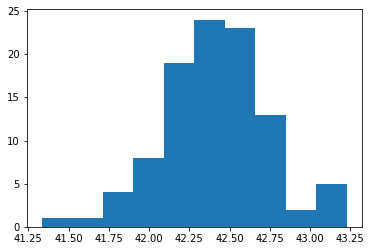

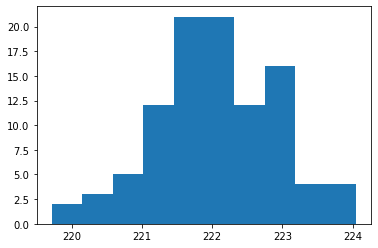

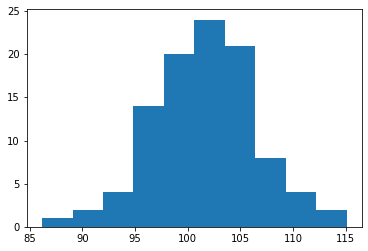

<Figure size 432x288 with 0 Axes>

In [632]:
plt.hist(win_pct, bins=10)
plt.show()
plt.clf()
plt.hist(daily_trades, bins=10)
plt.show()
plt.clf()
plt.hist(daily_profits, bins=10)
plt.show()
plt.clf()

In [654]:
class DeltaStackImbalanceStrategy(BaseStrategy):
    def __init__(self, of, k=0, kk=0, fixed_slippage=0, unit=1,max_profit=4,max_loss=2,
                trans_method='next', threshold1=1000, threshold2=3):
        super(DeltaStackImbalanceStrategy, self).__init__(of, k, kk, fixed_slippage, unit, max_profit,
                                           max_loss, trans_method)
        self.threshold1 = threshold1
        self.threshold2 = threshold2
        
    def next_step(self):
        if (self.delta[self.t] > self.threshold1) and (self.stacked_imb_buy[self.t] > self.threshold2):
            self.Open(self.time[self.t], self.t, -1)
        elif (self.delta[self.t] < -self.threshold1) and (self.stacked_imb_sell[self.t] > self.threshold2):
            self.Open(self.time[self.t], self.t, 1)
            
for threshold2 in np.arange(1, 10):
    for threshold1 in range(1000, 6000, 100):
        dsiStra = DeltaStackImbalanceStrategy(fg.of, threshold1=threshold1, threshold2=threshold2)
        dsiStra.run()
        dsiStra.summary()

        print(f'threshold1:{threshold1}\t threshold2:{threshold2} \t winning_pct:{dsiStra.winning_percent*100:.2f}%'\
              f' \t num_trades_per_day:{len(dsiStra.profit_line)/dsiStra.n_days:.2f}'\
              f' \t profit_per_day:{dsiStra.profits_np.cumsum()[-1]/dsiStra.n_days:.2f}')

threshold1:1000	 threshold2:1 	 winning_pct:44.07% 	 num_trades_per_day:44.19 	 profit_per_day:28.74
threshold1:1100	 threshold2:1 	 winning_pct:44.19% 	 num_trades_per_day:42.25 	 profit_per_day:27.54
threshold1:1200	 threshold2:1 	 winning_pct:44.31% 	 num_trades_per_day:40.20 	 profit_per_day:26.35
threshold1:1300	 threshold2:1 	 winning_pct:44.28% 	 num_trades_per_day:38.18 	 profit_per_day:24.80
threshold1:1400	 threshold2:1 	 winning_pct:44.33% 	 num_trades_per_day:36.32 	 profit_per_day:23.78
threshold1:1500	 threshold2:1 	 winning_pct:44.67% 	 num_trades_per_day:34.42 	 profit_per_day:23.06
threshold1:1600	 threshold2:1 	 winning_pct:45.21% 	 num_trades_per_day:32.65 	 profit_per_day:23.00
threshold1:1700	 threshold2:1 	 winning_pct:45.57% 	 num_trades_per_day:30.80 	 profit_per_day:22.45
threshold1:1800	 threshold2:1 	 winning_pct:45.38% 	 num_trades_per_day:29.09 	 profit_per_day:20.81
threshold1:1900	 threshold2:1 	 winning_pct:45.73% 	 num_trades_per_day:27.52 	 profit_per_

threshold1:4200	 threshold2:2 	 winning_pct:50.91% 	 num_trades_per_day:4.68 	 profit_per_day:4.91
threshold1:4300	 threshold2:2 	 winning_pct:51.03% 	 num_trades_per_day:4.53 	 profit_per_day:4.79
threshold1:4400	 threshold2:2 	 winning_pct:50.97% 	 num_trades_per_day:4.39 	 profit_per_day:4.62
threshold1:4500	 threshold2:2 	 winning_pct:51.20% 	 num_trades_per_day:4.24 	 profit_per_day:4.52
threshold1:4600	 threshold2:2 	 winning_pct:52.12% 	 num_trades_per_day:4.00 	 profit_per_day:4.48
threshold1:4700	 threshold2:2 	 winning_pct:52.09% 	 num_trades_per_day:3.86 	 profit_per_day:4.31
threshold1:4800	 threshold2:2 	 winning_pct:52.27% 	 num_trades_per_day:3.73 	 profit_per_day:4.21
threshold1:4900	 threshold2:2 	 winning_pct:52.35% 	 num_trades_per_day:3.61 	 profit_per_day:4.09
threshold1:5000	 threshold2:2 	 winning_pct:53.03% 	 num_trades_per_day:3.50 	 profit_per_day:4.11
threshold1:5100	 threshold2:2 	 winning_pct:53.28% 	 num_trades_per_day:3.36 	 profit_per_day:3.99
threshold1

threshold1:2500	 threshold2:4 	 winning_pct:45.67% 	 num_trades_per_day:3.23 	 profit_per_day:2.39
threshold1:2600	 threshold2:4 	 winning_pct:45.41% 	 num_trades_per_day:3.14 	 profit_per_day:2.27
threshold1:2700	 threshold2:4 	 winning_pct:44.72% 	 num_trades_per_day:3.05 	 profit_per_day:2.08
threshold1:2800	 threshold2:4 	 winning_pct:45.17% 	 num_trades_per_day:2.98 	 profit_per_day:2.12
threshold1:2900	 threshold2:4 	 winning_pct:45.75% 	 num_trades_per_day:2.89 	 profit_per_day:2.15
threshold1:3000	 threshold2:4 	 winning_pct:45.48% 	 num_trades_per_day:2.81 	 profit_per_day:2.05
threshold1:3100	 threshold2:4 	 winning_pct:45.12% 	 num_trades_per_day:2.78 	 profit_per_day:1.97
threshold1:3200	 threshold2:4 	 winning_pct:44.94% 	 num_trades_per_day:2.68 	 profit_per_day:1.86
threshold1:3300	 threshold2:4 	 winning_pct:45.75% 	 num_trades_per_day:2.59 	 profit_per_day:1.93
threshold1:3400	 threshold2:4 	 winning_pct:46.28% 	 num_trades_per_day:2.51 	 profit_per_day:1.95
threshold1

threshold1:5800	 threshold2:5 	 winning_pct:58.10% 	 num_trades_per_day:0.89 	 profit_per_day:1.32
threshold1:5900	 threshold2:5 	 winning_pct:57.69% 	 num_trades_per_day:0.88 	 profit_per_day:1.29
threshold1:1000	 threshold2:6 	 winning_pct:54.33% 	 num_trades_per_day:1.08 	 profit_per_day:1.36
threshold1:1100	 threshold2:6 	 winning_pct:54.33% 	 num_trades_per_day:1.08 	 profit_per_day:1.36
threshold1:1200	 threshold2:6 	 winning_pct:54.33% 	 num_trades_per_day:1.08 	 profit_per_day:1.36
threshold1:1300	 threshold2:6 	 winning_pct:54.33% 	 num_trades_per_day:1.08 	 profit_per_day:1.36
threshold1:1400	 threshold2:6 	 winning_pct:54.33% 	 num_trades_per_day:1.08 	 profit_per_day:1.36
threshold1:1500	 threshold2:6 	 winning_pct:54.33% 	 num_trades_per_day:1.08 	 profit_per_day:1.36
threshold1:1600	 threshold2:6 	 winning_pct:54.33% 	 num_trades_per_day:1.08 	 profit_per_day:1.36
threshold1:1700	 threshold2:6 	 winning_pct:53.97% 	 num_trades_per_day:1.07 	 profit_per_day:1.32
threshold1

threshold1:4100	 threshold2:7 	 winning_pct:57.81% 	 num_trades_per_day:0.54 	 profit_per_day:0.80
threshold1:4200	 threshold2:7 	 winning_pct:57.14% 	 num_trades_per_day:0.53 	 profit_per_day:0.76
threshold1:4300	 threshold2:7 	 winning_pct:57.14% 	 num_trades_per_day:0.53 	 profit_per_day:0.76
threshold1:4400	 threshold2:7 	 winning_pct:58.06% 	 num_trades_per_day:0.53 	 profit_per_day:0.78
threshold1:4500	 threshold2:7 	 winning_pct:58.06% 	 num_trades_per_day:0.53 	 profit_per_day:0.78
threshold1:4600	 threshold2:7 	 winning_pct:59.02% 	 num_trades_per_day:0.52 	 profit_per_day:0.80
threshold1:4700	 threshold2:7 	 winning_pct:59.02% 	 num_trades_per_day:0.52 	 profit_per_day:0.80
threshold1:4800	 threshold2:7 	 winning_pct:58.33% 	 num_trades_per_day:0.51 	 profit_per_day:0.76
threshold1:4900	 threshold2:7 	 winning_pct:58.33% 	 num_trades_per_day:0.51 	 profit_per_day:0.76
threshold1:5000	 threshold2:7 	 winning_pct:59.32% 	 num_trades_per_day:0.50 	 profit_per_day:0.78
threshold1

threshold1:2400	 threshold2:9 	 winning_pct:69.70% 	 num_trades_per_day:0.28 	 profit_per_day:0.61
threshold1:2500	 threshold2:9 	 winning_pct:69.70% 	 num_trades_per_day:0.28 	 profit_per_day:0.61
threshold1:2600	 threshold2:9 	 winning_pct:69.70% 	 num_trades_per_day:0.28 	 profit_per_day:0.61
threshold1:2700	 threshold2:9 	 winning_pct:69.70% 	 num_trades_per_day:0.28 	 profit_per_day:0.61
threshold1:2800	 threshold2:9 	 winning_pct:69.70% 	 num_trades_per_day:0.28 	 profit_per_day:0.61
threshold1:2900	 threshold2:9 	 winning_pct:69.70% 	 num_trades_per_day:0.28 	 profit_per_day:0.61
threshold1:3000	 threshold2:9 	 winning_pct:69.70% 	 num_trades_per_day:0.28 	 profit_per_day:0.61
threshold1:3100	 threshold2:9 	 winning_pct:69.70% 	 num_trades_per_day:0.28 	 profit_per_day:0.61
threshold1:3200	 threshold2:9 	 winning_pct:69.70% 	 num_trades_per_day:0.28 	 profit_per_day:0.61
threshold1:3300	 threshold2:9 	 winning_pct:69.70% 	 num_trades_per_day:0.28 	 profit_per_day:0.61
threshold1